<a href="https://colab.research.google.com/github/sbbwoy/ESAA/blob/main/220328_Ensemble_Learning_%26Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#앙상블 학습과 랜덤 포레스트

앙상블 학습Ensemble learning: 일련의 예측기(앙상블)로부터 예측을 수집해 가장 좋은 모델을 얻음

결정 트리의 앙상블: 랜덤 포레스트Random Forest

##7.1 투표 기반 분류기

직접 투표 분류기

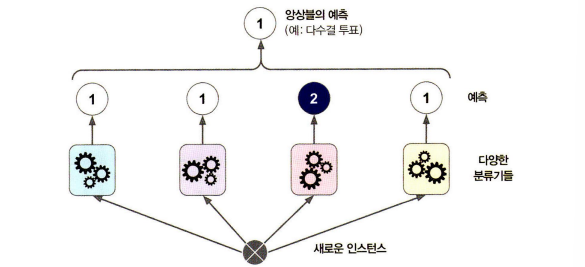

각 분류기가 약한 학습기라도 충분히 많고 다양하면 그 앙상블은 강한 학습기가 될 수 있음. 이는 대수의 법칙laws of large numbers

**앙상블 방법은 예측기가 가능한 한 상호 독립적일 때 최고의 성능을 발휘함. 다양한 분류기를 얻는 방법은 각기 다른 알고리즘으로 학습시키는 것. 이로 앙상블 모델의 정확도를 향상시킴**

In [5]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

In [7]:
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [9]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.88
SVC 0.896
VotingClassifier 0.912


**간접 투표**: 모든 분류기에 predict_proba() 메소드가 있으면 개별 분류기의 예측의 평균을 계산한 후 확률이 가장 높은 클래스를 예측할 수 있음. 확률이 높은 투표에 비중을 두기 때문에 직접 투표보다 성능이 높음. (voting='soft') 사용.

* SVC에서는 기본값으로 클래스 확률을 제공하지 않아 probability 매개변수를 True로 지정해야 함

##7.2 배깅과 페이스팅

**배깅**: bootstrap aggregating. 훈련 세트에서 중복을 허용해 샘플링하는 방식
**페이스팅**: pasting. 중복을 허용하지 않고 샘플링하는 방식

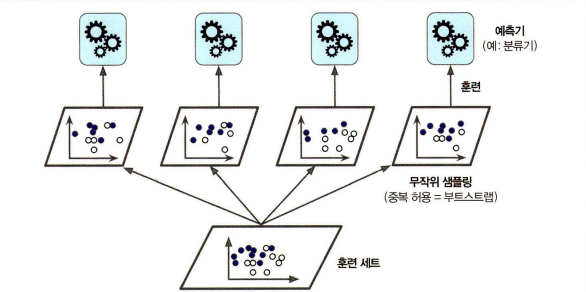

수집 함수는 전형적으로 분류일 때는 통계적 최빈값, 회귀일 때는 평균을 계산.
개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 크게 편향 되나 수집 함수를 통과하면 편향과 분산이 모두 감소함.

###7.2.1 사이킷런의 배깅과 페이스팅

BaggingClassifier / BaggingRegressor (각각 분류 / 회귀)

* BaggingClassifier는 사용하는 알고리즘 모델(분류기)가 각 예측 클래스의 확률을 추정할 수 있으면, 직접 투표(hard voting)대신 간접 투표(soft voting) 방식을 사용한다.

In [12]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [18]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print('Accuracy =', accuracy_score(y_test, y_pred_tree))

Accuracy = 0.856


In [14]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)    #n_jobs: 훈련과 예측에 사용할 CPU 코어 수를 지정. -1은 가용한 모든 코어 사용
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

print('Accuracy =', accuracy_score(y_test, y_pred))

Accuracy = 0.904


결정트리에 비해 0.5나 정확도가 높게 나옴

In [16]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

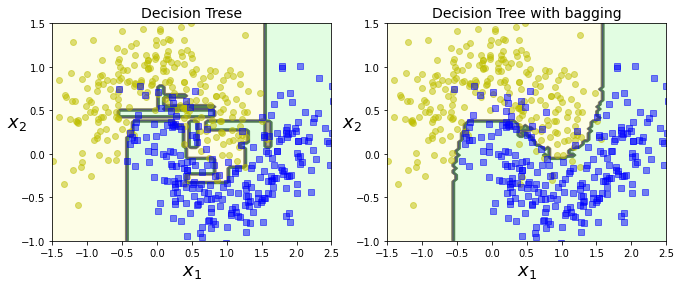

In [17]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Trese", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Tree with bagging", fontsize=14)
plt.show()

##7.2 ood 평가

배깅 사용시, 어떤 것은 여러 번 샘플링 되는 반면 어떤 것은 전혀 선택되지 않을 수 있을 수 있음. BaggingClassifier는 기본값으로 중복을 허용해 훈련 세트의 크기만큼인 m개 샘플을 선택. 
--> 평균적으로 각 예측기에 63% 정도 샘플링됨 37%의 나머지를 ood 샘플이라고 부름

* BaggingClassifier(oob_score=True): 훈련 종료 후 oob 평가 수행

In [21]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

BaggingClassifier는 테스트 세트에서 90.1% 정확도를 얻을 것으로 예측됨

In [22]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

90.4%로 아주 유사한 결과

In [23]:
bag_clf.oob_decision_function_

array([[0.29378531, 0.70621469],
       [0.31318681, 0.68681319],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.00520833, 0.99479167],
       [0.0989011 , 0.9010989 ],
       [0.33939394, 0.66060606],
       [0.03592814, 0.96407186],
       [0.98469388, 0.01530612],
       [0.98974359, 0.01025641],
       [0.77540107, 0.22459893],
       [0.        , 1.        ],
       [0.78735632, 0.21264368],
       [0.87912088, 0.12087912],
       [0.96276596, 0.03723404],
       [0.039801  , 0.960199  ],
       [0.        , 1.        ],
       [0.97395833, 0.02604167],
       [0.96666667, 0.03333333],
       [0.99462366, 0.00537634],
       [0.04812834, 0.95187166],
       [0.31034483, 0.68965517],
       [0.92783505, 0.07216495],
       [1.        , 0.        ],
       [0.95      , 0.05      ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.63095238, 0.36904762],
       [0.

##7.3 랜덤 패치와 랜덤 서브스페이스

* BaggingClassifier는 특성 샘플링도 지원.
* max_features, bootstrap_features로 조절할 수 있음
* 이미지 같이 매우 고차원의 데이터셋을 다룰 때 유용
* 랜덤 패치 방식: 훈련 특성과 샘플을 모두 샘플링하는 것
* 랜덤 서브스페이스 방식: 훈련 샘플을 모두 사용(bootstrap=False, max_samples=1.0) 특성은 샘플링(bootstrap_features=True 그리고/또는 max_features는 1.0보다 작게 설정)하는 것

* 특성 샘플링은 더 다양한 예측기를 만들어 편향을 늘리나 분산을 낮춤

##7.4 랜덤 포레스트

결정 트리의 앙상블로, RandomForestClassifier를 사용.

* 랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중 최적의 특성을 찾는 식으로 무작위성을 더 주입
* 편향이 늘어나나 분산이 낮아져 전체적으로 더 나은 모델이 됨

In [25]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print('Accuracy =', accuracy_score(y_test, y_pred))

Accuracy = 0.904


###7.4.1 엑스트라 트리extra tree

: 트리를 더 랜덤하게 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 랜덤으로 분할한 다음 최상의 분할을 선택

* 이 방법 또한 편향이 늘어나고 분산이 낮아짐.
* 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠름
* ExtraTreesClassifier() 사용
* RandomForestClassifier와 ExtraTreesClassifier 중 뭐가 더 낫다고 판단 X 교차 검증 필요.

### 7.4.2 특성 중요도

* 랜덤 포레스트는 특성의 상대적 중요도를 측정하기 쉽다는 장점을 가짐
* 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인해 특성의 중요도를 측정. 
* 특성을 선택해야 할 때 어떤 특성이 중요한지 빠르게 확인할 수 있어 편리함

In [26]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10387031791042428
sepal width (cm) 0.025060667917626574
petal length (cm) 0.44117349753376117
petal width (cm) 0.42989551663818804


In [30]:
from tensorflow.keras.datasets import mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [31]:
X = np.vstack((train_x, test_x))
X = X.reshape([-1, 28*28])
y = np.append(train_y, test_y)

rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(X, y)

RandomForestClassifier(random_state=42)

In [29]:
import matplotlib as mat
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mat.cm.hot,
               interpolation="nearest")
    plt.axis("off")

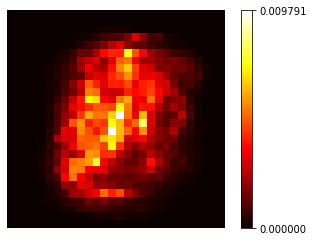

In [32]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])

plt.show()

##7.5 부스팅
: 약한 학습기를 여러 개 연결해 강한 학습기를 만드는 앙상블 방법

###7.5.1 adaptive boosting
*  이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것
* 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높이고 두 번째 분류기에서 업데이트된 가중치를 사용해 훈련하고 다시 예측, 반복.

    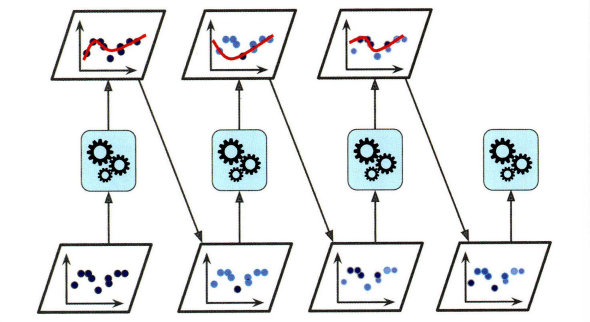


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [34]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

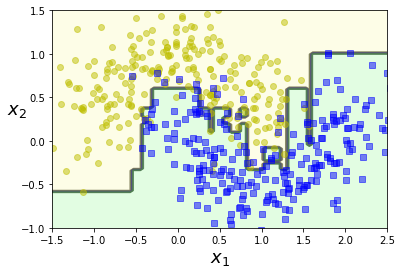

In [35]:
plot_decision_boundary(ada_clf, X, y)

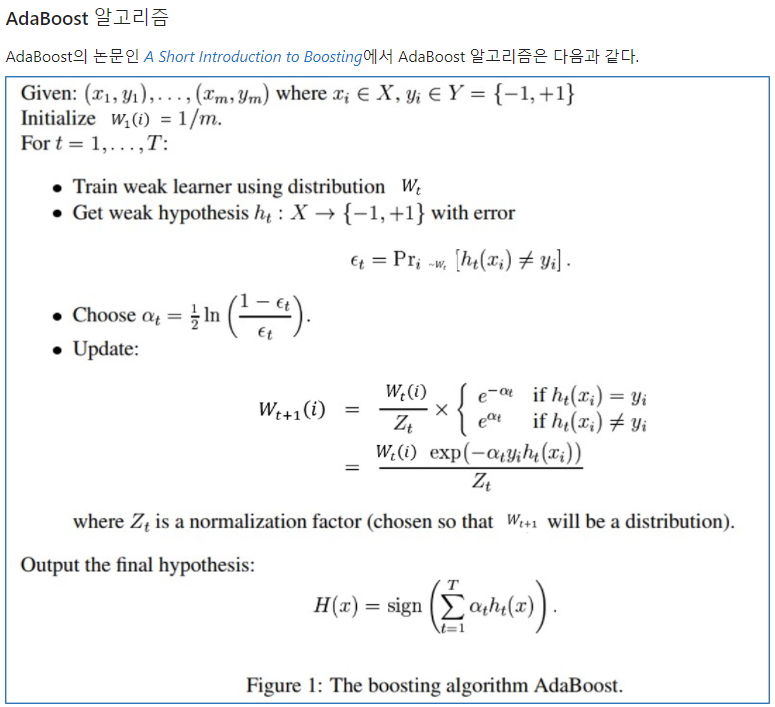

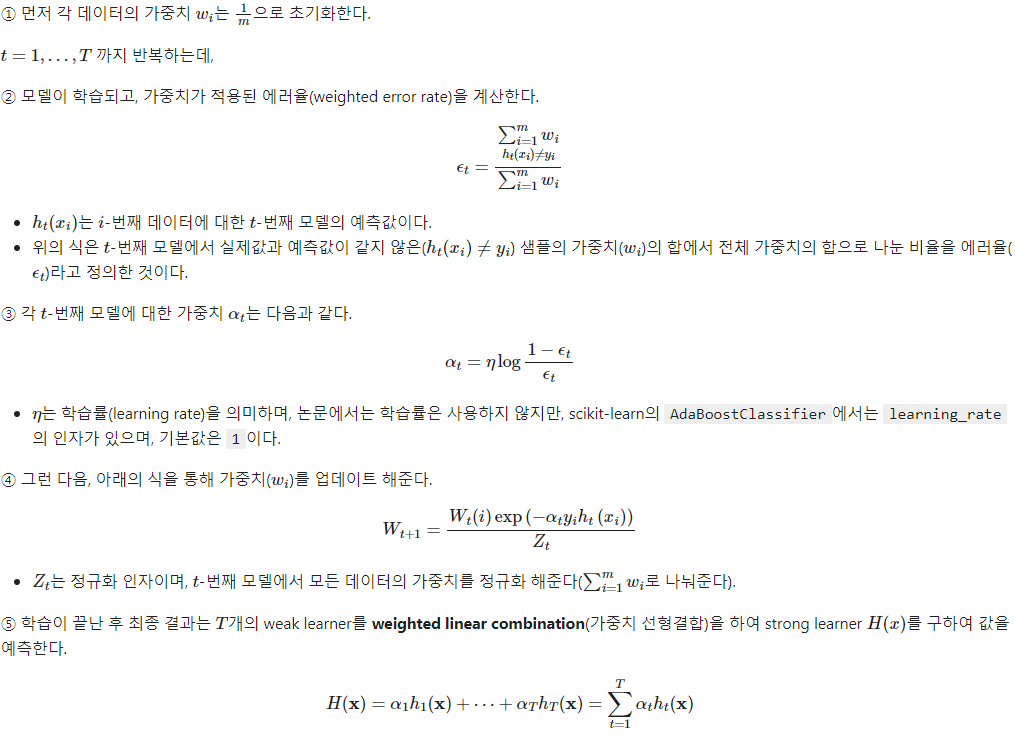

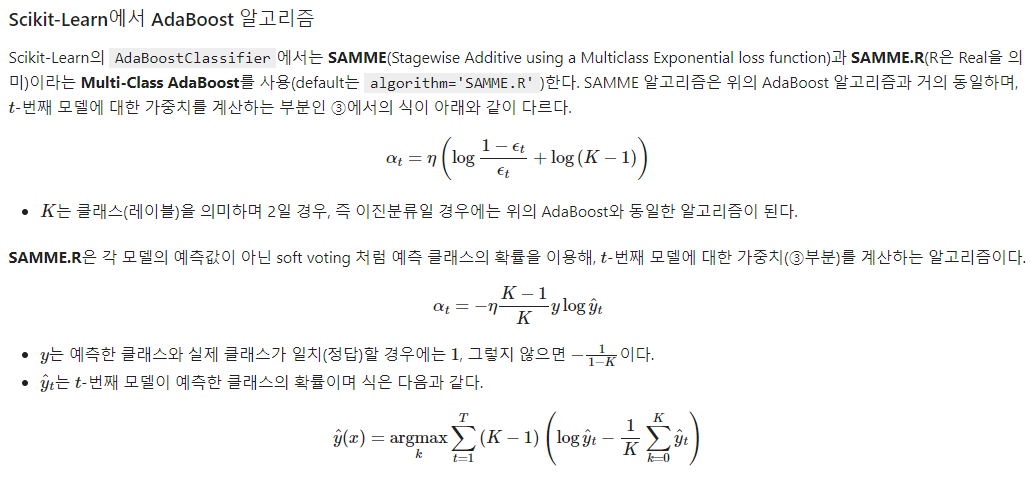

###7.5.2 gradient boosting
* 학습 단계마다 데이터 샘플의 가중치를 업데이트 해주는 것이 아니라 학습 전단계 모델에서의 잔여 오차(residual error)에 대해 새로운 모델을 학습시키는 방법
* learning_rate: 각 트리의 기여 정도를 조절
    * 0.1과 같이 낮게 설정하면 예측 성능은 좋지만 많은 트리가 필요함 <-- 축소

In [37]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

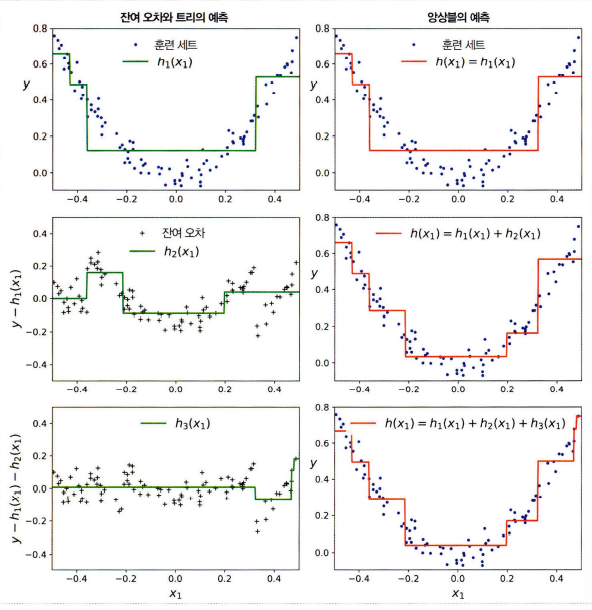

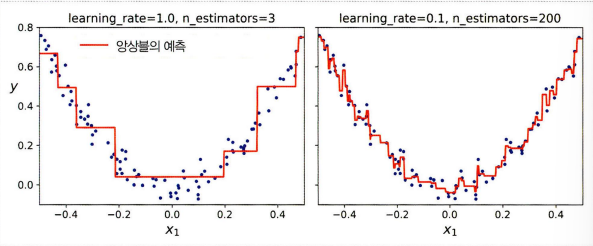

왼쪽은 트리가 충분하지 않음. 오른쪽은 트리가 많아 과대적합됨

In [47]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

# 최적의 트리 개수 찾기
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
best_n_estimators = np.argmin(errors)

# 최적의 트리개수로 그래디언트 부스팅 학습
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=104, random_state=42)

In [41]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52572 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0, flags=flags)


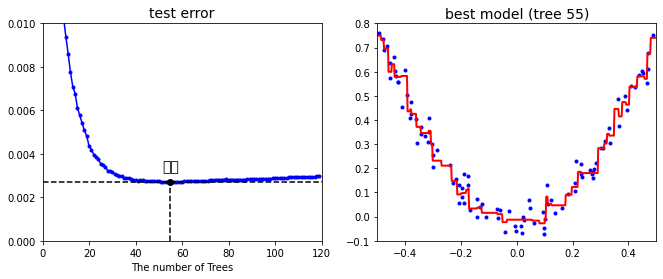

In [51]:
min_error = np.min(errors)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.text(best_n_estimators, min_error*1.2, "최소", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("The number of Trees")
plt.title("test error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("best model (tree %d)" % best_n_estimators, fontsize=14)

plt.show()

In [52]:
#조기종료

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

In [53]:
print('최적의 트리 개수 :', gbrt.n_estimators)
print("최소 검증 MSE:", min_val_error)

최적의 트리 개수 : 61
최소 검증 MSE: 0.002712853325235463


##7.6 스태킹stacking, stacked generalization
: 앙상블 학습에서 각 모델의 예측값을 가지고 새로운 메타 모델(meta learner)을 학습시켜 최종 예측 모델을 만드는 방법

* 블랜딩 예측기를 사용한 예측 취합

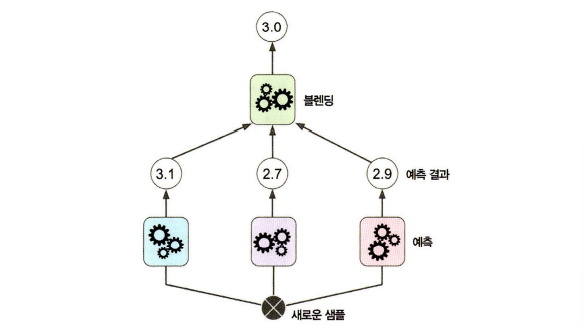